# Testing
### Eheschliessung nach Nationalität der Eheschliessenden, seit 1993

https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_ehe_nationalitaet_od3305

https://data.stadt-zuerich.ch/dataset/bev_ehe_nationalitaet_od3305

Datum: 02.11.2021

### Importiere die notwendigen Packages

In [18]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [19]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io


In [20]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [21]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [22]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [23]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [24]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 11 datenstand:  9 time.struct_time(tm_year=2022, tm_mon=11, tm_mday=3, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=307, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [25]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [26]:
package_name = "bev_ehe_nationalitaet_od3305"

In [27]:
dataset_name = "BEV330OD3305.csv"

**Statische Pfade in DWH-Dropzones**

In [28]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [29]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [30]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [31]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [32]:
from IPython.display import Markdown as md

In [33]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_ehe_nationalitaet_od3305 

In [34]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_ehe_nationalitaet_od3305 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [35]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [36]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_ehe_nationalitaet_od3305/download/BEV330OD3305.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [37]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr      datetime64[ns]
NationEp1HistCd               int64
NationEp1HistLang            object
NationEp1HistSort             int64
NationEp2HistCd               int64
NationEp2HistLang            object
NationEp2HistSort             int64
RegionEp1Cd                   int64
RegionEp1Lang                object
RegionEp1Sort                 int64
RegionEp2Cd                   int64
RegionEp2Lang                object
RegionEp2Sort                 int64
KontinentEp1Cd                int64
KontinentEp1Lang             object
KontinentEp1Sort              int64
KontinentEp2Cd                int64
KontinentEp2Lang             object
KontinentEp2Sort              int64
SexEp1Cd                      int64
SexEp1Lang                   object
SexEp1Kurz                   object
SexEp2Cd                      int64
SexEp2Lang                   object
SexEp2Kurz                   object
AnzSchl                       int64
dtype: object

Berechne weitere Attribute falls notwendig

In [38]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
NationEp1HistCd                 int64
NationEp1HistLang              object
NationEp1HistSort               int64
NationEp2HistCd                 int64
NationEp2HistLang              object
NationEp2HistSort               int64
RegionEp1Cd                     int64
RegionEp1Lang                  object
RegionEp1Sort                   int64
RegionEp2Cd                     int64
RegionEp2Lang                  object
RegionEp2Sort                   int64
KontinentEp1Cd                  int64
KontinentEp1Lang               object
KontinentEp1Sort                int64
KontinentEp2Cd                  int64
KontinentEp2Lang               object
KontinentEp2Sort                int64
SexEp1Cd                        int64
SexEp1Lang                     object
SexEp1Kurz                     object
SexEp2Cd                        int64
SexEp2Lang                     object
SexEp2Kurz                     object
AnzSchl                         int64
StichtagDatJ

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [39]:
#data2betested.head(6)

In [40]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
NationEp1HistCd                 int64
NationEp1HistLang              object
NationEp1HistSort               int64
NationEp2HistCd                 int64
NationEp2HistLang              object
NationEp2HistSort               int64
RegionEp1Cd                     int64
RegionEp1Lang                  object
RegionEp1Sort                   int64
RegionEp2Cd                     int64
RegionEp2Lang                  object
RegionEp2Sort                   int64
KontinentEp1Cd                  int64
KontinentEp1Lang               object
KontinentEp1Sort                int64
KontinentEp2Cd                  int64
KontinentEp2Lang               object
KontinentEp2Sort                int64
SexEp1Cd                        int64
SexEp1Lang                     object
SexEp1Kurz                     object
SexEp2Cd                        int64
SexEp2Lang                     object
SexEp2Kurz                     object
AnzSchl                         int64
StichtagDatJ

In [41]:
data2betested.shape

(14532, 27)

Beschreibe einzelne Attribute

In [42]:
data2betested.describe()

NationEp1HistCd  NationEp1HistSort  NationEp2HistCd  NationEp2HistSort  RegionEp1Cd  \
count            14532              14532            14532              14532        14532   
mean              8323               8323             8303               8303           25   
std                210                210              195                195           19   
min               8100               8100             8100               8100           11   
25%               8212               8212             8207               8207           13   
50%               8249               8249             8236               8236           16   
75%               8423               8423             8406               8406           34   
max               8999               8999             8999               8999           88   

       RegionEp1Sort  RegionEp2Cd  RegionEp2Sort  KontinentEp1Cd  KontinentEp1Sort  \
count          14532        14532          14532           14532             14532   
mean              25           24             24               2                 2   
std               19           17             17               2                 2   
min               11           11             11               1                 1   
25%               13           13             13               1                 1   
50%               16           16             16               1                 1   
75%               34           31             31               3                 3   
max               88           88             88               8                 8   

       KontinentEp2Cd  KontinentEp2Sort  SexEp1Cd  SexEp2Cd  AnzSchl  
count           14532             14532     14532     14532    14532  
mean                2                 2         2         1        7  
std                 2                 2         0         0       46  
min                 1                 1         2         1        1  
25%                 1                 1         2         1        1  
50%                 1                 1         2         1        1  
75%                 3                 3         2         1        4  
max                 8                 8         2         1     1143

Wie viele Nullwerte gibt es im Datensatz?

In [43]:
data2betested.isnull().sum()

StichtagDatJahr        0
NationEp1HistCd        0
NationEp1HistLang      0
NationEp1HistSort      0
NationEp2HistCd        0
NationEp2HistLang      0
NationEp2HistSort      0
RegionEp1Cd            0
RegionEp1Lang          0
RegionEp1Sort          0
RegionEp2Cd            0
RegionEp2Lang          0
RegionEp2Sort          0
KontinentEp1Cd         0
KontinentEp1Lang       0
KontinentEp1Sort       0
KontinentEp2Cd         0
KontinentEp2Lang       0
KontinentEp2Sort       0
SexEp1Cd               0
SexEp1Lang             0
SexEp1Kurz             0
SexEp2Cd               0
SexEp2Lang             0
SexEp2Kurz             0
AnzSchl                0
StichtagDatJahr_str    0
dtype: int64

Welches sind die Quartiere ohne Werte bei AnzBestWir?

In [44]:
data2betested[np.isnan(data2betested.AnzSchl)]

Empty DataFrame
Columns: [StichtagDatJahr, NationEp1HistCd, NationEp1HistLang, NationEp1HistSort, NationEp2HistCd, NationEp2HistLang, NationEp2HistSort, RegionEp1Cd, RegionEp1Lang, RegionEp1Sort, RegionEp2Cd, RegionEp2Lang, RegionEp2Sort, KontinentEp1Cd, KontinentEp1Lang, KontinentEp1Sort, KontinentEp2Cd, KontinentEp2Lang, KontinentEp2Sort, SexEp1Cd, SexEp1Lang, SexEp1Kurz, SexEp2Cd, SexEp2Lang, SexEp2Kurz, AnzSchl, StichtagDatJahr_str]
Index: []

[0 rows x 27 columns]

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [45]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [46]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14532 entries, 2021-01-01 to 1993-01-01
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NationEp1HistCd      14532 non-null  int64 
 1   NationEp1HistLang    14532 non-null  object
 2   NationEp1HistSort    14532 non-null  int64 
 3   NationEp2HistCd      14532 non-null  int64 
 4   NationEp2HistLang    14532 non-null  object
 5   NationEp2HistSort    14532 non-null  int64 
 6   RegionEp1Cd          14532 non-null  int64 
 7   RegionEp1Lang        14532 non-null  object
 8   RegionEp1Sort        14532 non-null  int64 
 9   RegionEp2Cd          14532 non-null  int64 
 10  RegionEp2Lang        14532 non-null  object
 11  RegionEp2Sort        14532 non-null  int64 
 12  KontinentEp1Cd       14532 non-null  int64 
 13  KontinentEp1Lang     14532 non-null  object
 14  KontinentEp1Sort     14532 non-null  int64 
 15  KontinentEp2Cd       14532 non-null 

Int64Index([1], dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [47]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [48]:
data2betested.loc["2021"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

NationEp1HistCd NationEp1HistLang  NationEp1HistSort  NationEp2HistCd  \
StichtagDatJahr                                                                          
2021-01-01                  8999   Staat unbekannt               8999             8546   
2021-01-01                  8218           Italien               8218             8250   

                NationEp2HistLang  NationEp2HistSort  RegionEp1Cd  ... SexEp1Lang  SexEp1Kurz  \
StichtagDatJahr                                                    ...                          
2021-01-01            Bangladesch               8546           88  ...   weiblich           W   
2021-01-01               Kroatien               8250           16  ...   weiblich           W   

                 SexEp2Cd SexEp2Lang  SexEp2Kurz  AnzSchl StichtagDatJahr_str  
StichtagDatJahr                                                                
2021-01-01              1   männlich           M        1          2021-01-01  
2021-01-01              1   männlich           M        1          2021-01-01  

[2 rows x 26 columns]

### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung nach Altersgruppe

In [49]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1993":"2021"]\
    .groupby(['StichtagDatJahr']) \
    .agg(sum_AnzSchl=('AnzSchl', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

StichtagDatJahr  sum_AnzSchl
0      1993-01-01         3571
1      1994-01-01         3541
2      1995-01-01         3180

In [50]:
myTitle="Anzahl Eheschliessungen"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['StichtagDatJahr_str'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_AnzSchl>1'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzSchl', axis=alt.Axis(title='Anz. Personen'))
    #, color=alt.Color('AlterV05Kurz', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'sum_AnzSchl']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [65]:
myGrpSelection = data2betested.loc["1993":"2020"]\
    .groupby(['StichtagDatJahr', 'RegionEp1Lang', 'RegionEp1Sort']) \
    .agg(sum_AnzSchl=('AnzSchl', 'sum')) \
    .sort_values('sum_AnzSchl', ascending=False) 
myGrpSelection.reset_index().columns

Index(['StichtagDatJahr', 'RegionEp1Lang', 'RegionEp1Sort', 'sum_AnzSchl'], dtype='object')

In [66]:
#data2betested.columns

In [69]:
myTitle="Anzahl Eheschliessungen nach Herkunft des Ehepartners 1 nicht aus Zentraleuropa"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['RegionEp1Lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myGrpSelection.reset_index().query('RegionEp1Lang!="Zentraleuropa"'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzSchl', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('RegionEp1Lang', legend=alt.Legend(title="Region Ehepartner 1", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'RegionEp1Lang','sum_AnzSchl']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [70]:
data2betested.columns

Index(['NationEp1HistCd', 'NationEp1HistLang', 'NationEp1HistSort', 'NationEp2HistCd',
       'NationEp2HistLang', 'NationEp2HistSort', 'RegionEp1Cd', 'RegionEp1Lang', 'RegionEp1Sort',
       'RegionEp2Cd', 'RegionEp2Lang', 'RegionEp2Sort', 'KontinentEp1Cd', 'KontinentEp1Lang',
       'KontinentEp1Sort', 'KontinentEp2Cd', 'KontinentEp2Lang', 'KontinentEp2Sort', 'SexEp1Cd',
       'SexEp1Lang', 'SexEp1Kurz', 'SexEp2Cd', 'SexEp2Lang', 'SexEp2Kurz', 'AnzSchl',
       'StichtagDatJahr_str'],
      dtype='object')

In [79]:
myAggBar = data2betested\
    .groupby(['StichtagDatJahr','RegionEp1Lang','RegionEp1Sort', 'KontinentEp1Lang', 'KontinentEp1Sort']) \
    .agg(sum_AnzSchl=('AnzSchl', 'sum')) \
    .sort_values('sum_AnzSchl', ascending=False) \
    .head(1000)

myAggBar.reset_index().columns

Index(['StichtagDatJahr', 'RegionEp1Lang', 'RegionEp1Sort', 'KontinentEp1Lang', 'KontinentEp1Sort',
       'sum_AnzSchl'],
      dtype='object')

In [80]:
myAggBar2 = data2betested.reset_index()\
    .groupby(['StichtagDatJahr','RegionEp2Lang','RegionEp2Sort','KontinentEp2Lang', 'KontinentEp2Sort']) \
    .agg(sum_AnzSchl=('AnzSchl', 'sum')) \
    .sort_values('sum_AnzSchl', ascending=False) \
    .head(1000)

myAggBar2.reset_index().columns

Index(['StichtagDatJahr', 'RegionEp2Lang', 'RegionEp2Sort', 'KontinentEp2Lang', 'KontinentEp2Sort',
       'sum_AnzSchl'],
      dtype='object')

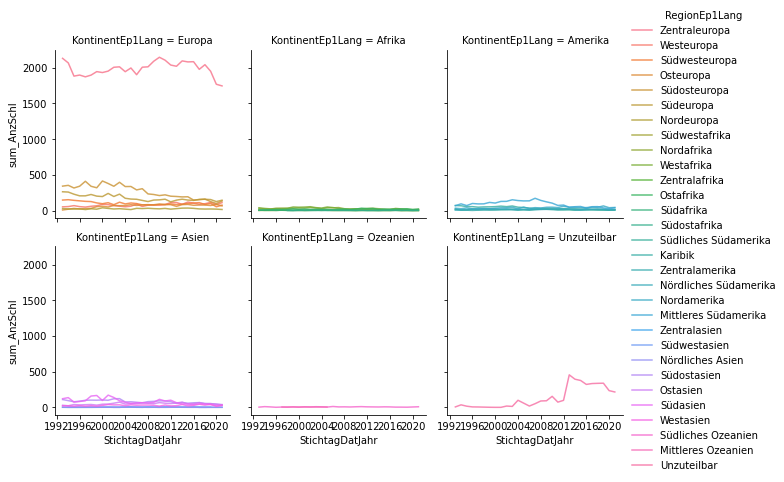

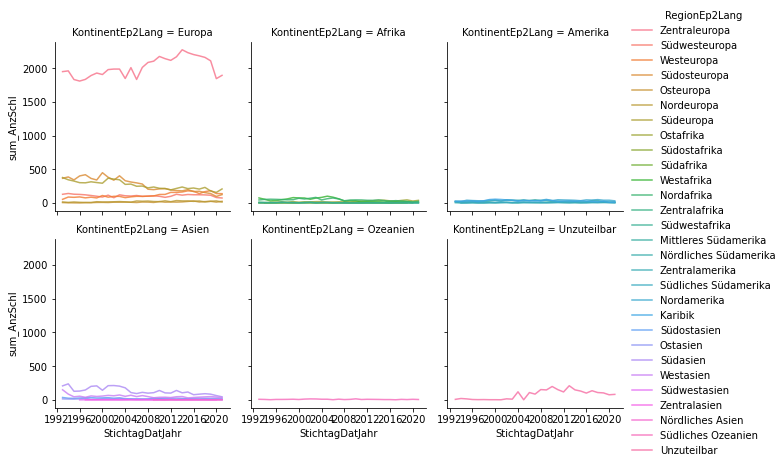

In [81]:
#g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="HerkunftLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "AlterV05Sort", "sum_WBev", alpha=.8)
#g.add_legend()

g2 = sns.FacetGrid(myAggBar.reset_index().sort_values('KontinentEp1Sort', ascending=True), col="KontinentEp1Lang", hue="RegionEp1Lang", col_wrap=3, height=3,)
g2.map(sns.lineplot, "StichtagDatJahr","sum_AnzSchl",alpha=.8)

g2.add_legend()


g2 = sns.FacetGrid(myAggBar2.reset_index().sort_values('KontinentEp2Sort', ascending=True), col="KontinentEp2Lang", hue="RegionEp2Lang", col_wrap=3, height=3,)
g2.map(sns.lineplot, "StichtagDatJahr","sum_AnzSchl",alpha=.8)

g2.add_legend()

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Quartier, Herkunft und Geschlecht

In [82]:
data2betested.reset_index().columns

Index(['StichtagDatJahr', 'NationEp1HistCd', 'NationEp1HistLang', 'NationEp1HistSort',
       'NationEp2HistCd', 'NationEp2HistLang', 'NationEp2HistSort', 'RegionEp1Cd', 'RegionEp1Lang',
       'RegionEp1Sort', 'RegionEp2Cd', 'RegionEp2Lang', 'RegionEp2Sort', 'KontinentEp1Cd',
       'KontinentEp1Lang', 'KontinentEp1Sort', 'KontinentEp2Cd', 'KontinentEp2Lang',
       'KontinentEp2Sort', 'SexEp1Cd', 'SexEp1Lang', 'SexEp1Kurz', 'SexEp2Cd', 'SexEp2Lang',
       'SexEp2Kurz', 'AnzSchl', 'StichtagDatJahr_str'],
      dtype='object')

In [113]:
myTreemapAgg = data2betested.loc["2011":"2021"]  \
    .groupby(['StichtagDatJahr','NationEp1HistCd', 'NationEp1HistLang', 'NationEp1HistSort',
              'NationEp2HistCd', 'NationEp2HistLang', 'NationEp2HistSort',
              'KontinentEp1Cd', 'KontinentEp1Lang', 'KontinentEp1Sort',
              'KontinentEp2Cd', 'KontinentEp2Lang', 'KontinentEp2Sort']) \
    .agg(sum_AnzSchl=('AnzSchl', 'sum')) \
    .sort_values('sum_AnzSchl', ascending=True) 

myTreemapAgg.reset_index().head(3)

StichtagDatJahr  NationEp1HistCd NationEp1HistLang  NationEp1HistSort  NationEp2HistCd  \
0      2021-01-01             8999   Staat unbekannt               8999             8546   
1      2016-01-01             8514            Israel               8514             8207   
2      2016-01-01             8515             Japan               8515             8212   

  NationEp2HistLang  NationEp2HistSort  KontinentEp1Cd KontinentEp1Lang  KontinentEp1Sort  \
0       Bangladesch               8546               8      Unzuteilbar                 8   
1       Deutschland               8207               4            Asien                 4   
2        Frankreich               8212               4            Asien                 4   

   KontinentEp2Cd KontinentEp2Lang  KontinentEp2Sort  sum_AnzSchl  
0               4            Asien                 4            1  
1               1           Europa                 1            1  
2               1           Europa                 1            1

In [114]:
myTreemapAgg.reset_index().columns

Index(['StichtagDatJahr', 'NationEp1HistCd', 'NationEp1HistLang', 'NationEp1HistSort',
       'NationEp2HistCd', 'NationEp2HistLang', 'NationEp2HistSort', 'KontinentEp1Cd',
       'KontinentEp1Lang', 'KontinentEp1Sort', 'KontinentEp2Cd', 'KontinentEp2Lang',
       'KontinentEp2Sort', 'sum_AnzSchl'],
      dtype='object')

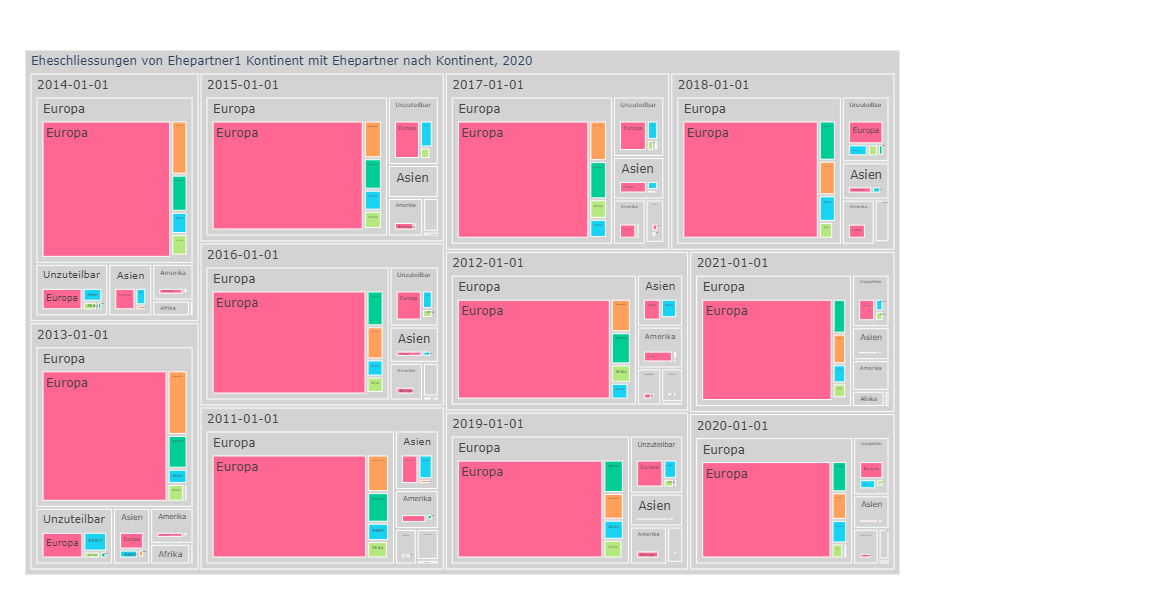

In [115]:
fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant("Eheschliessungen von Ehepartner1 Kontinent mit Ehepartner nach Kontinent, 2020"),'StichtagDatJahr','KontinentEp1Lang','KontinentEp2Lang'
                                                  ]
                 , values='sum_AnzSchl'
                 , color='KontinentEp2Lang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','Deutschland':'gold', 'Schweiz':'#FF3030', 'Türkei':'#EE3B3B', 'Serbien':'#A2CD5A','Kosovo':'#CAFF70','Österreich':'orange','Italien':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=600
                 ,width=1300                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [116]:
myTreemapAgg.reset_index().columns

Index(['StichtagDatJahr', 'NationEp1HistCd', 'NationEp1HistLang', 'NationEp1HistSort',
       'NationEp2HistCd', 'NationEp2HistLang', 'NationEp2HistSort', 'KontinentEp1Cd',
       'KontinentEp1Lang', 'KontinentEp1Sort', 'KontinentEp2Cd', 'KontinentEp2Lang',
       'KontinentEp2Sort', 'sum_AnzSchl'],
      dtype='object')

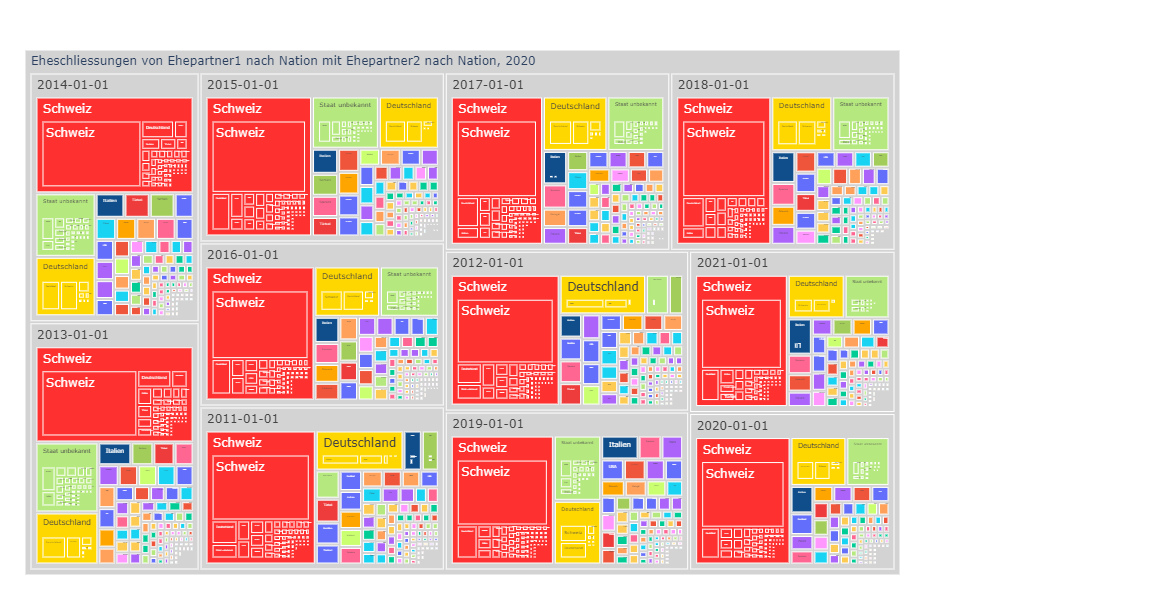

In [117]:
fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant("Eheschliessungen von Ehepartner1 nach Nation mit Ehepartner2 nach Nation, 2020"), 'StichtagDatJahr','NationEp1HistLang','NationEp2HistLang',]
                 , values='sum_AnzSchl'
                 , color='NationEp1HistLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','Deutschland':'gold', 'Schweiz':'#FF3030', 'Türkei':'#EE3B3B', 'Serbien':'#A2CD5A','Kosovo':'#CAFF70','Österreich':'orange','Italien':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=600
                 ,width=1300                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=897&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**